# Détection des bad buzz grâce au deep learning

Vous êtes ingénieur IA chez MIC (Marketing Intelligence Consulting), une entreprise de conseil spécialisée sur les problématiques de marketing digital.

La compagnie aérienne Air Paradis a missionné votre cabinet pour créer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux. Il est vrai que “Air Paradis” n’a pas toujours bonne presse sur les réseaux…

### Import des librairies

In [54]:
# Import des librairies pour la manipulation des données
import pandas as pd

# Import des librairies pour la visualisation des données
import matplotlib.pyplot as plt

# Import des librairies pour la modelisation 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

# Import des librairies de traitement de langage
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nolwenn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nolwenn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Nolwenn\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nolwenn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nolwenn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Jeu de données

In [2]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', delimiter=',', encoding='ISO-8859-1', header=None)

In [3]:
df.shape

(1600000, 6)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [6]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Le jeu de données contient 1,6 million de tweets extrait de l'api twitter. Les tweets sont annotés de 0 (negative) à 4 (positive) et peuvent être utilisés pour prédire les sentiments.

In [7]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Il y a le même nombre de tweets positifs que de tweets négatifs. Il n'y aura pas de problème de déséquilibre de classe lorsque nous entraînerons notre modèle.

On ne va conserver que la target et le text.

In [8]:
# on ne garde que les colonnes target et text
df.drop(columns=["id", "date", "flag", "user"], inplace=True)

Etapes :

- Echantillonage
- Pre-processing
- Vectorisation
- Reduction de dimension
- Train and test model
- Visualisation

## Echantillonnage

In [9]:
# récupération des targets
target_values = df['target'].value_counts().index.to_list()
target_values

[0, 4]

In [11]:
# échantillonage,  on garde 1% de chaque target
list_targets = []
list_texts = []
for target in target_values:
    dataframe = df[df['target'] == target].sample(frac=0.01)
    list_targets.extend(dataframe['target'])
    list_texts.extend(dataframe['text'])

data = pd.DataFrame()
data['text'] = list_texts
data['target'] = list_targets

data

,text,target
0,I miss my blackberry,0
1,@sonialexandra but I couldn't start until fall...,0
2,"Just another bad day, cuz of realsoftware. #re...",0
3,Buyin crap to clean up crap! Poor Toby sick,0
4,I hate hate hate not ever being able to sleep ...,0
...,...,...
15995,Morning twittwers Event expo this morning .......,4
15996,@Pivo1 Thanks mate,4
15997,@andybui no probs...i found u on imdb.com,4
15998,@Padmasree - and execution without a vision is...,4


## Pre-processing

Avec [spacy](https://spacy.io/)

In [20]:
nlp = spacy.load("en_core_web_sm")

Define a function that

- removes stopwords
- removes punctuation signs
- lemmatizes the text

In [21]:
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    return ' '.join(tokens)

In [22]:
text = '''These are the good times; Leave your cares behind'''
print(preprocess(text))

good time leave care


Add a couple of punctuation signs with multi charaters as stopwords to the nlp spacy model

In [23]:
nlp.Defaults.stop_words.add("`,")
nlp.Defaults.stop_words.add("``")

In [24]:
data['processed_text'] = data.text.apply(lambda txt : preprocess(txt))

short text with just a few tokens won't have enough information for the classification model that we want to train. Let's add a count of the number of tokens for each text and filter out the text with less than N tokens.

In [25]:
data['token_count'] = data.processed_text.apply(lambda txt : len(txt.split())  )

In [26]:
data.token_count.describe()

count    16000.000000
mean         6.906937
std          3.661214
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         35.000000
Name: token_count, dtype: float64

<AxesSubplot: >

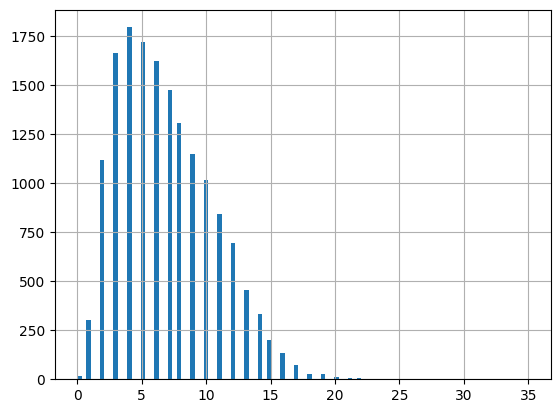

In [29]:
data.token_count.hist(bins = 100)

In [31]:
data = data[data.token_count > 4]
data.reset_index(inplace = True, drop = True)

In [32]:
data[data.token_count > 4].target.value_counts()

4    5643
0    5459
Name: target, dtype: int64

## Vectorisation

In [36]:
cv = CountVectorizer()
X = cv.fit_transform(data.processed_text)

In [37]:
X.shape

(11102, 20648)

In [38]:
# define the target variable
y = data.target

## Modelling

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
print(X_train.shape)
print(X_test.shape)

(8881, 20648)
(2221, 20648)


In [59]:
# 1. Declare the model
clf = LogisticRegressionCV(cv=5)

# 2. Train the model
clf.fit(X_train, y_train)

# 3. Make predictions  on test set
yhat = clf.predict(X_test)

# 4. score
print("Accuracy: ",accuracy_score(y_test, yhat))

c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Accuracy:  0.7104907699234579


On va comparer avec la vectorisation TD-IDF

In [61]:

cv = TfidfVectorizer()
X = cv.fit_transform(data.processed_text)
y = data.target

# split test train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train and evaluate the model
# 1. Declare the model
clf = LogisticRegressionCV(cv=5)

# 2. Train the model
clf.fit(X_train, y_train)

# 3. Make predictions  on test set
yhat = clf.predict(X_test)

# 4. score
print("Accuracy: ",accuracy_score(y_test, yhat))

c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Accuracy:  0.7104907699234579


Pas de différence dans ce cas

In [67]:
def plot_classifier(classifier, X_test, y_test):

    # confusion matrix
    clf_predictions = classifier.predict(X_test)
    cm = confusion_matrix(y_test, clf_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # ROC curve
    RocCurveDisplay.from_estimator(classifier, X_test, y_test)
    plt.show()

    # Precision Recall curve
    PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test)
    plt.show()

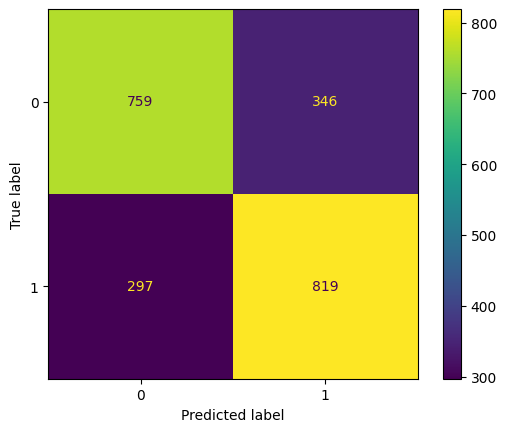

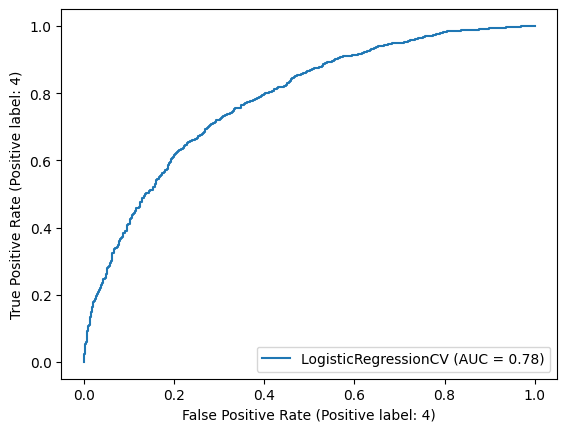

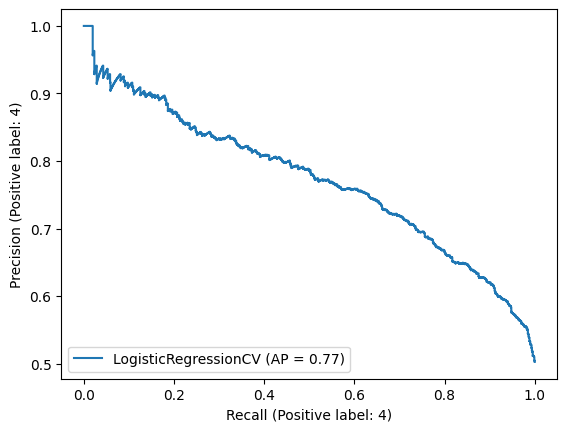

In [68]:
plot_classifier(clf, X_test, y_test)